In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

##Loading in data file
csv_data = "Manhattan12.csv"
df = pd.read_csv(csv_data, header = 4)

In [2]:
##Show the shape of the dataset
print(df.shape)

(27395, 21)


In [3]:
##Rename incorrectly formatted column names 
def remove_newlines(df):
    old_columns = df.columns
    cleaned_columns = [col.replace("\n", " ") for col in old_columns]
    #Renaming DF columns
    df.rename(dict(zip(old_columns, cleaned_columns)), axis = 1, inplace = True)
    return df

df = remove_newlines(df)

In [4]:
##Create list of categorical variables and numerical values 
cat_variables = list(df.select_dtypes(include=['category', 'object']))
num_variables = list(df.select_dtypes(include=['int', 'float']))
print(num_variables)

['BOROUGH', 'BLOCK', 'LOT', 'ZIP CODE', 'COMMERCIAL UNITS', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']


In [5]:
##For each numerical column, remove the ',' the '$' for the sale price, and then convert them to numeric.
def clean_numericals(df, df_numericals_list):
    for column in df_numericals_list:
        df[column] = df[column].astype("string")
        df[column] = df[column].str.replace('$','', regex = True)
        df[column] = df[column].str.replace(",", "", regex = True)
        df[column] = pd.to_numeric(df[column])
    return df
#appending sale price and sale date to num_variables to convert it also
num_variables.append("SALE PRICE")
df = clean_numericals(df, num_variables)


In [6]:
##Convert SALE_DATE to datetime
df["SALE DATE"] = pd.to_datetime(df["SALE DATE"], format = '%d/%m/%Y')

In [7]:
## For each categorical variable, replace with NaNs. Also same with 0s
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.strip().replace('', np.nan)

#Need to convert columns to numeric for replacement
numeric_conversion_list = ["RESIDENTIAL UNITS", "TOTAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET"]
df = clean_numericals(df, numeric_conversion_list)
df.replace(0,np.nan, inplace=True)

    

In [8]:
##Show a summary of all missing values as well as the summary statistics
print(df.describe())
#Missing values
df.isnull().sum()


       BOROUGH         BLOCK           LOT  EASE-MENT      ZIP CODE  \
count  27395.0  27395.000000  27395.000000        0.0  27394.000000   
mean       1.0   1109.666728    741.789086        NaN  10029.226217   
std        0.0    465.994469    819.422424        NaN     34.966983   
min        1.0      7.000000      1.000000        NaN  10001.000000   
25%        1.0    877.000000     37.000000        NaN  10016.000000   
50%        1.0   1047.000000   1007.000000        NaN  10019.000000   
75%        1.0   1411.000000   1233.000000        NaN  10027.000000   
max        1.0   2250.000000   9117.000000        NaN  10463.000000   

       RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  \
count       11023.000000       3433.000000  17691.000000       4489.000000   
mean            4.390003          2.992426      3.545249       5893.466028   
std            23.260831         12.689861     19.482767       7884.729624   
min             1.000000          1.000000      

BOROUGH                               0
NEIGHBORHOOD                         17
BUILDING CLASS CATEGORY            3454
TAX CLASS AT PRESENT                143
BLOCK                                 0
LOT                                   0
EASE-MENT                         27395
BUILDING CLASS AT PRESENT           143
ADDRESS                               0
APART MENT NUMBER                 14570
ZIP CODE                              1
RESIDENTIAL UNITS                 16372
COMMERCIAL UNITS                  23962
TOTAL UNITS                        9704
LAND SQUARE FEET                  22906
GROSS SQUARE FEET                 23069
YEAR BUILT                         6441
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                         7593
SALE DATE                             0
dtype: int64

In [9]:
def drop_columns(df, drop_columns_list):
    for column in drop_columns_list:
        df.drop([column], axis = 1, inplace = True)
    return df
    
drop_columns_list = ['BOROUGH','EASE-MENT','APART MENT NUMBER']

df = drop_columns(df, drop_columns_list)
df

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1306,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,2214693.0,2013-05-20
1,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1307,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1654656.0,2013-05-16
2,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1308,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1069162.0,2013-05-23
3,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1309,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1374637.0,2013-05-15
4,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1310,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1649565.0,2013-05-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27390,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2170,400,V1,44 FAIRVIEW AVENUE,10040.0,NaN,NaN,NaN,16217.0,NaN,NaN,4,V1,NaN,2013-04-29
27391,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,75,V1,BENNETT AVENUE,10033.0,NaN,NaN,NaN,4150.0,NaN,NaN,4,V1,495000.0,2013-06-26
27392,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,75,V1,BENNETT AVENUE,10033.0,NaN,NaN,NaN,4150.0,NaN,NaN,4,V1,NaN,2013-04-02
27393,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,76,V1,N/A MAGAW PLACE,10033.0,NaN,NaN,NaN,760.0,NaN,NaN,4,V1,NaN,2013-06-26


In [10]:
##Drop duplicates
df.drop_duplicates(inplace=True)

In [11]:
##Drop NAN 

In [12]:
df = df.dropna()
df

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
24,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,385,1,C7,17 AVENUE B,10009.0,7.0,1.0,8.0,2093.0,5852.0,1997.0,2,C7,283.0,2013-04-18
26,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,397,33,C7,14 AVENUE B,10009.0,25.0,2.0,27.0,3574.0,18212.0,1925.0,2,C7,13185684.0,2013-01-31
30,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,398,53,C7,170 EAST 2ND STREET,10009.0,36.0,3.0,39.0,4452.0,17664.0,1900.0,2,C7,3810602.0,2012-10-26
31,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,400,56,C4,203 EAST 4TH STREET,10009.0,10.0,1.0,10.0,2404.0,6975.0,1900.0,2,C4,7333333.0,2013-04-09
32,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,400,57,C4,201 EAST 4TH STREET,10009.0,9.0,1.0,9.0,2404.0,6875.0,1900.0,2,C4,7333333.0,2013-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27057,WASHINGTON HEIGHTS UPPER,07 RENTALS - WALKUP APARTMENTS,2,2180,13,C7,500 FT WASHINGTON AVENUE,10033.0,56.0,1.0,57.0,14150.0,44295.0,1925.0,2,C7,8620000.0,2013-03-22
27059,WASHINGTON HEIGHTS UPPER,07 RENTALS - WALKUP APARTMENTS,2,2180,120,C7,4321 BROADWAY,10033.0,69.0,5.0,74.0,12400.0,54000.0,1949.0,2,C7,11400000.0,2013-04-11
27060,WASHINGTON HEIGHTS UPPER,08 RENTALS - ELEVATOR APARTMENTS,2,2158,16,D7,440 AUDUBON AVENUE,10040.0,68.0,3.0,71.0,14231.0,66240.0,1911.0,2,D7,7810000.0,2012-08-29
27064,WASHINGTON HEIGHTS UPPER,08 RENTALS - ELEVATOR APARTMENTS,2,2175,33,D7,4720 BROADWAY,10040.0,50.0,2.0,52.0,12050.0,52378.0,1920.0,2,D7,11360000.0,2013-05-30


In [13]:
##Removing outliers
#This is Ella's code, this may be worth looking at
df = df.select_dtypes(include = ['int','float'])
def removing_outliers (df, threshold):
    num_df = df.select_dtypes(include = ['int','float'])
    z = np.abs((num_df - num_df.mean()) / num_df.std())  ## calclulating the z score for numerical columns in the dataframe
    outliers = df[(z > threshold).any(axis=1)]  ## outliers identified in the datframe
    
    
    return df[(z <= threshold).all (axis =1)]    ## returns a df with the removal of outliers from the dataframe

df = removing_outliers (df, 3)
df

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
26,397,33,10009.0,25.0,2.0,27.0,3574.0,18212.0,1925.0,2,13185684.0
30,398,53,10009.0,36.0,3.0,39.0,4452.0,17664.0,1900.0,2,3810602.0
31,400,56,10009.0,10.0,1.0,10.0,2404.0,6975.0,1900.0,2,7333333.0
32,400,57,10009.0,9.0,1.0,9.0,2404.0,6875.0,1900.0,2,7333333.0
33,400,58,10009.0,9.0,1.0,10.0,2404.0,7110.0,1900.0,2,7333333.0
...,...,...,...,...,...,...,...,...,...,...,...
27052,2175,45,10040.0,68.0,6.0,74.0,15800.0,58400.0,1920.0,2,11300000.0
27057,2180,13,10033.0,56.0,1.0,57.0,14150.0,44295.0,1925.0,2,8620000.0
27059,2180,120,10033.0,69.0,5.0,74.0,12400.0,54000.0,1949.0,2,11400000.0
27060,2158,16,10040.0,68.0,3.0,71.0,14231.0,66240.0,1911.0,2,7810000.0


In [14]:
##Show the shape of the resulting dataframe
df.shape

(428, 11)

In [15]:
##Consider the log of the prices and normalise the data.
df["LOG PRICE"] = np.log(df["SALE PRICE"])

#maybe log all of the values as well? might make correlation better
# for columns in df:
#     df[columns] = np.log(df[columns])


#Normalising the data using code from tutorial workshop
def normalise(df):
    num_cols = df.select_dtypes(include=[np.number]).copy()
    df_norm = ((num_cols - num_cols.min()) / (num_cols.max() - num_cols.min()))
    return df_norm

##df = normalise(df)


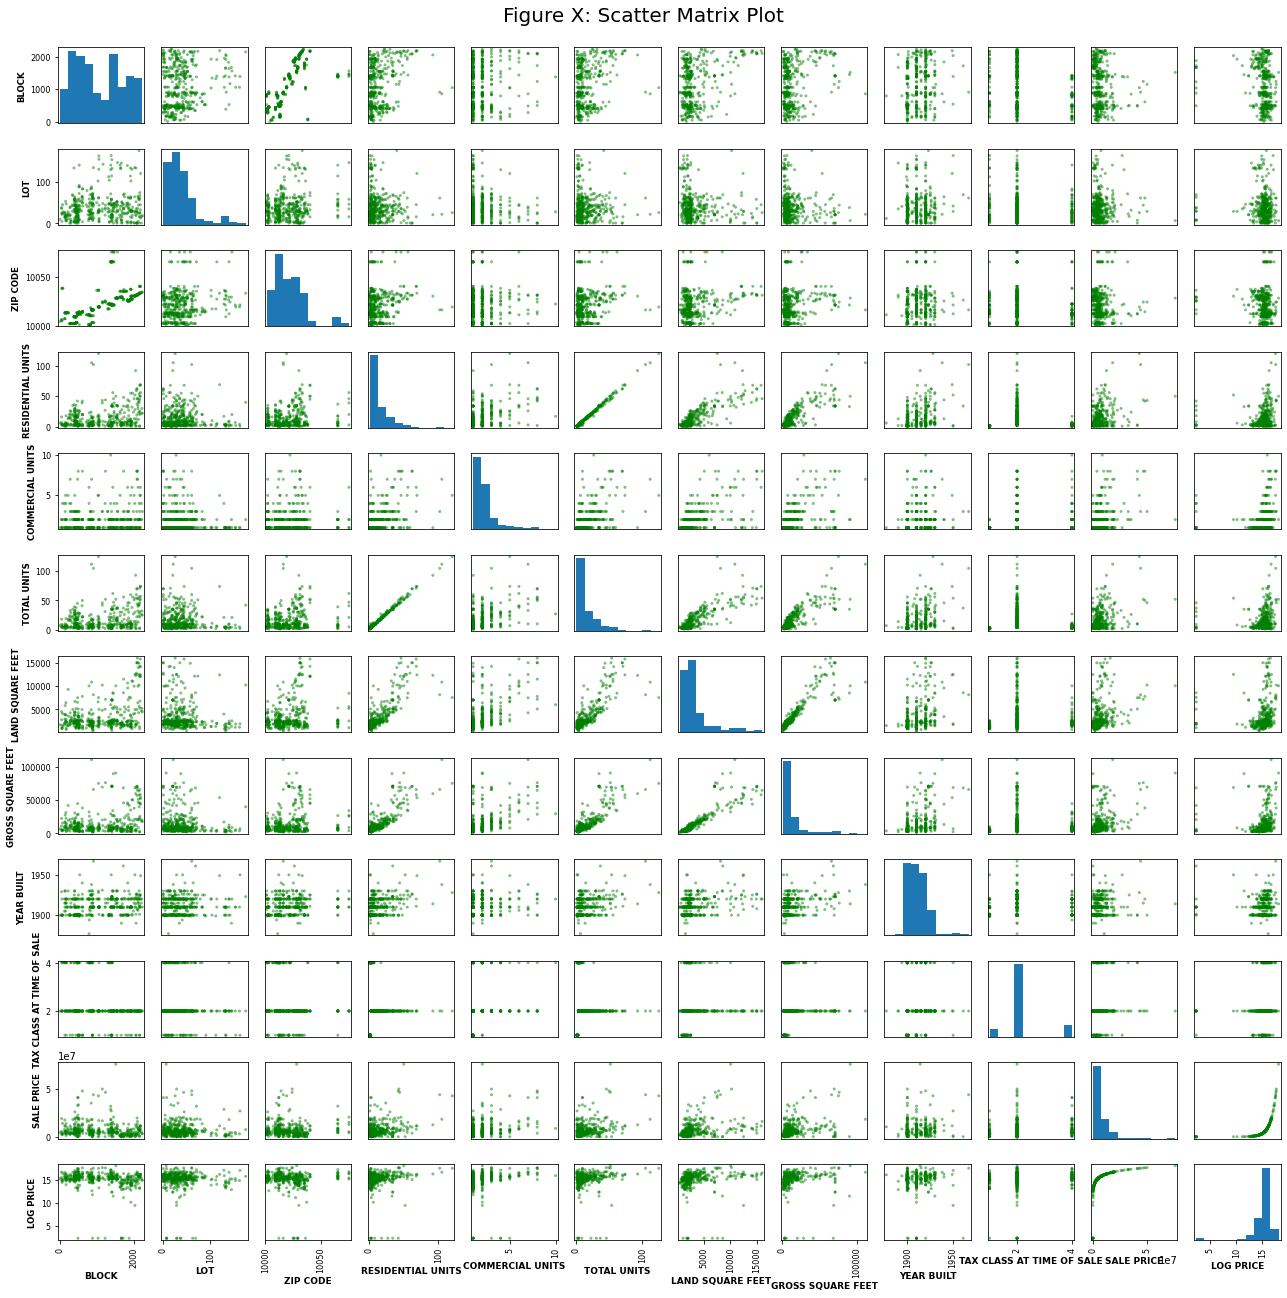

In [16]:
##Data exploration
scatt_matrix=pd.plotting.scatter_matrix(df, figsize=(18,18), diagonal='hist',color='green')
plt.suptitle('Figure X: Scatter Matrix Plot', fontsize=20,y=1)
plt.tight_layout()  ## gives the gaps inbetween
## now adjusting the axis lables for each subplot to make legible
for ax in scatt_matrix.flatten():
    # Set x label to corresponding variable name
    ax.set_xlabel(ax.get_xlabel(), fontsize=9)
    # Set y label to corresponding variable name
    ax.set_ylabel(ax.get_ylabel(), fontsize=8.6)
    #making the font of the text bolder
    ax.title.set_fontweight('bold')
    ax.xaxis.label.set_fontweight('bold')
    ax.yaxis.label.set_fontweight('bold')
plt.show()



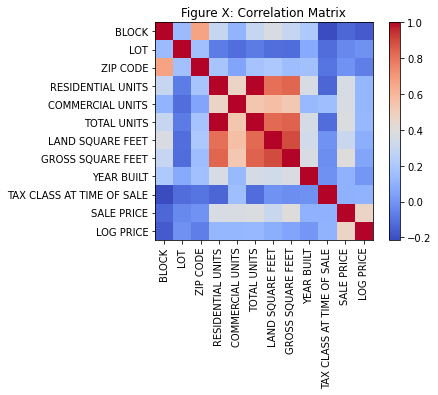

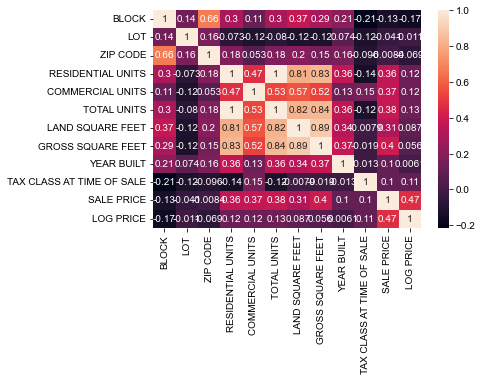

<Figure size 1296x1152 with 0 Axes>

In [17]:
# create correlation matrix
corr_matrix = df.corr()
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Figure X: Correlation Matrix')
plt.show()

sns.heatmap(df.corr(),annot=True)
plt.figure(figsize = (18,16))
sns.set(font_scale=0.6)  ## adjsuting the font size of the numbers in the heatmap
plt.show()

[15.4728786  15.13969977 15.56583422 16.14400629 15.3847652  15.58738764
 13.83548499 15.65765983 14.7404813  15.16266292 15.43996975 15.79029921
 15.7126842  15.35731836 14.99549819 15.4607507  15.79645426 15.51676153
 16.08967804 14.85642227 15.51618618 13.86518226 15.52208127 16.29113027
 15.0365914  15.97307217 15.59462317 14.40819027 16.08573218 15.19884405
 14.1897853  14.99613149 13.61259991 14.42699584  6.56460672 14.93343272
 15.64149438 16.37944099 15.4073718  15.8010436  15.45132708 13.77941102
 15.5025368  15.30885667 13.94852876 15.5276383  14.49928189 13.82679605
 13.52037108 15.59298775 15.76180812 15.14116422 15.86389373 15.00818077
 15.0843098  15.33844813 15.28000941 15.54243581 15.57602056 14.94210402
  6.56460672 15.18718225 15.72625112 12.30043737 15.89875192 13.17639577
 15.58780139 15.49254193 15.55022731 15.48516596 14.67162474 15.18936049
 15.59307531 13.9445466  15.71354297 15.12338707 15.71701104 15.62199187
 15.56789467 15.66848256 15.70083833 14.50111283 15

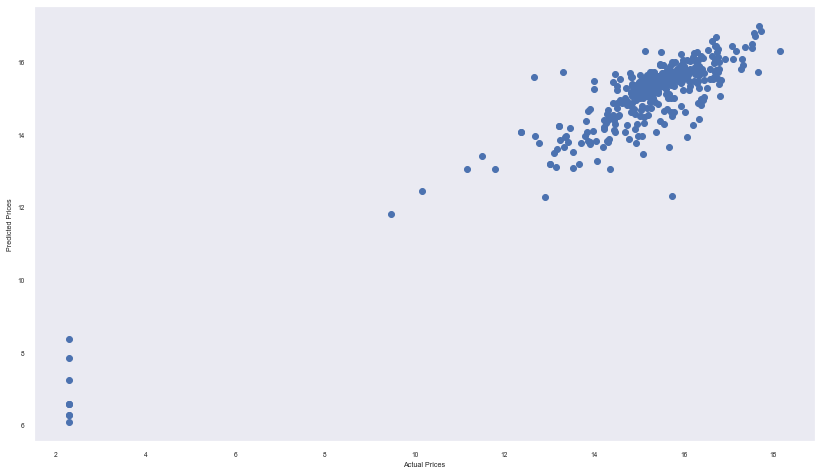

In [18]:
##Create model
features = ['BLOCK', 'LOT', 'ZIP CODE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']
X = df[features]
Y = df['LOG PRICE']

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0)

#lmodel = linear_model.LinearRegression()
#treeModel = DecisionTreeRegressor(random_state=1)
forestModel = RandomForestRegressor(random_state=0, max_depth = 7)

forestModel.fit(trainX, trainY)

pred_home_prices = forestModel.predict(testX)
mae = mean_absolute_error(testY, pred_home_prices)

print(pred_home_prices)
print(f'Mean absolute error: {mae}')

print(forestModel.score(trainX, trainY))

print(forestModel.score(testX, testY))

pred_Y = forestModel.predict(X)
plt.figure(figsize=(14, 8))
plt.plot(Y, pred_Y, 'o')
plb.xlabel('Actual Prices')
plb.ylabel('Predicted Prices')
plt.grid()
plt.show()